### Vegetation sensitivity

trying to get consectutive counts for timeseries to make hardcoded FAO value (2months per year) more robust

NOTE: `virtual_product_cat.yaml` has been altered, need `virtual_product_cat_veg_testing.yaml`, provided in slack

In [15]:
import os, sys
import xarray as xr
import numpy as np
import pandas
from matplotlib import pyplot as plt

import datacube
from datacube.storage import masking
from datacube.helpers import write_geotiff
from datacube.utils.geometry import CRS
dc = datacube.Datacube(app="veg_sensitivity")

from numba import jit

In [16]:
# # 13, -28 (Central west QLD, 2010 veg, 2015 bare)
# x = (1300000, 1350000)
# y = (-2750000, -2700000)

# # 13, -28 (Central west QLD, 2010 veg, 2015 bare) not square
# x = (1300000, 1325000)
# y = (-2750000, -2700000)

# # small area
# x = (1101550, 1101650)
# y = (-3970125, -3970225)

# # small area not square
# x = (1101550, 1101650)
# y = (-3970125, -3970175)

res = (-100, 100)
crs = "EPSG:3577"
time = ("2010-01-01", "2010-12-31")
query =({'time': time,
             'x':x,
            'y':y,
            'crs':crs,
            'resolution':res})

# AWS or Gadi
service = '/home/jovyan/development/'
# service = '/g/data/r78/LCCS_Aberystwyth/co6850/'

#### create the same virtual product as vegetat_veg_cat

In [17]:
sys.path.append(os.path.abspath(str(service)+"livingearth_australia/le_plugins"))
sys.path.append(str(service)+"dea-notebooks/Scripts")
sys.path.append(str(service)+"livingearth_australia")

os.environ["LE_LCCS_PLUGINS_PATH"] = str(service)+"livingearth_australia/le_plugins"

# Import le_lccs modules
from le_lccs.le_ingest import gridded_ingest
from le_lccs import le_export
from le_lccs.le_classification import lccs_l3
from le_lccs.le_classification import lccs_l4

# datacube functions to load in a virtual product from recipe
from datacube.virtual import catalog_from_file
catalog = catalog_from_file(str(service)+'livingearth_australia/le_plugins/virtual_product_cat_veg_testing.yaml')

In [22]:
# load from datacube virtual product
# product = catalog['vegetat_veg_cat']
# can remove ls7 if not wanted
product = catalog['vegetat_veg_cat_ls7removed']
data = product.load(dc, **query)
data

<xarray.Dataset>
Dimensions:  (time: 26, x: 500, y: 500)
Coordinates:
  * y        (y) float64 -3.9e+06 -3.9e+06 -3.9e+06 ... -3.95e+06 -3.95e+06
  * x        (x) float64 1.65e+06 1.65e+06 1.65e+06 ... 1.7e+06 1.7e+06 1.7e+06
  * time     (time) datetime64[ns] 2010-01-20T23:41:06.500000 ... 2010-12-14T23:43:18.500000
Data variables:
    BS       (time, y, x) int16 1 2 2 2 2 4 2 4 4 ... 53 63 58 62 55 62 57 54 51
    PV       (time, y, x) int16 50 51 56 55 53 49 48 49 ... 21 21 20 21 21 23 23
    NPV      (time, y, x) int16 49 46 42 44 44 47 49 48 ... 22 18 25 18 22 24 28
    water    (time, y, x) int16 0 0 0 0 0 0 0 0 0 0 0 ... 4 4 4 4 4 4 4 4 4 4 4
Attributes:
    crs:      EPSG:3577

#### monthly aggregation


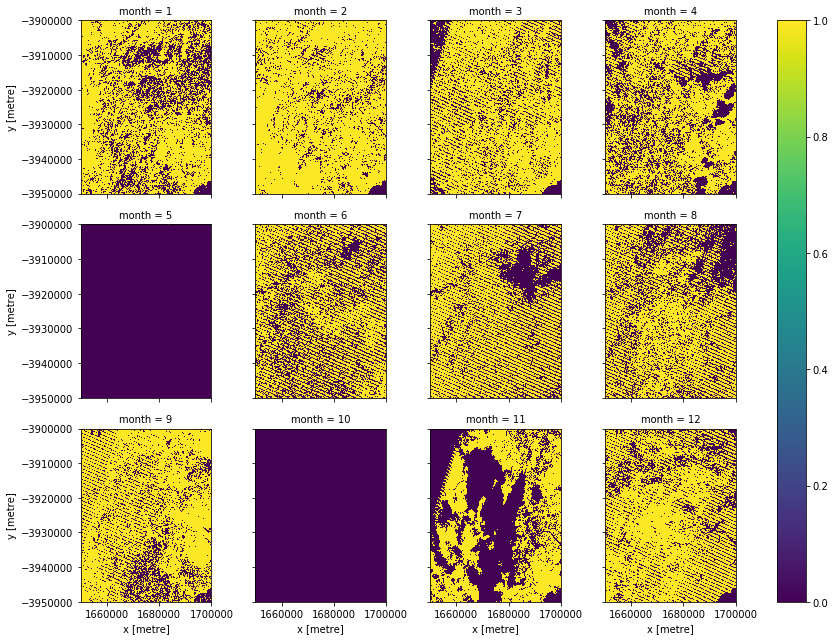

In [23]:
# masking out no data areas before groupby so that no data is not considered for median function
data_mask = data.where((data['BS'] > 0) & (data['PV'] > 0))
data_month = data_mask.groupby('time.month').median(dim='time')

# run pluging rules #
# Create mask where BS < PV
tv_mask = data_month['BS'] < data_month['PV']

# Can't trust FC where there is water
# Mask where clear water was observed in WOfS (128: clear and wet, 132: clear, wet & sea)
tv = tv_mask.where((data_month['water'] != 128), 0)
tv = tv_mask.where((data_month['water'] != 132), 0)
tv.plot(col='month', col_wrap=4)

#### consecutive counting function

In [24]:
def consecutive_count(tv_numpy, consecutive_numpy, required_consecutive=2, consec_msk_val=1):
    '''
    function to get consective count of veg (1) for each pixel across the time series
    
    :param numpy.array tv_numpy: 3-D array of tv[z,y,x]
    :param numpy.array consecutive_numpy: bool output array for veg (1) and non veg (0)
    :param float required_consecutive: how many consectutive 1's to be classified as veg?
    :param float consec_msk_val: what value to calculcate consectutives on
           default is veg (1)     
    '''
    for y in range(tv_numpy.shape[1]):
        for x in range(tv_numpy.shape[2]):
            # num_consecutive set to 1 as if statement below requires looking at previous value
            # therefore cannot use required_consecutive=1, however not a problem
            # as we wouldn't want to know anything >=2 for required_consecutive
            num_consecutive = 1
            max_num_consecutive = 0
            # Go through all dates looking for consecutive values
            for z in range(1, tv_numpy.shape[0]):
                # If value is the same as previous date and same as consec_msk_val
                # iterate number of consecutive
                if (tv_numpy[z-1,y,x] == tv_numpy[z,y,x]) and (tv_numpy[z,y,x] == consec_msk_val):
                    num_consecutive += 1
                    if num_consecutive > max_num_consecutive:
                        max_num_consecutive = num_consecutive
                # If not reset counter
                else:
                    num_consecutive = 1
            # If there enough consecutive 1's for required_consecutive
            # Set output to veg (1)
            if max_num_consecutive >= required_consecutive:
                consecutive_numpy[y,x] = 1
            else:
                 consecutive_numpy[y,x] = 0
    return consecutive_numpy


(1650000.0, 1700000.0, -3950000.0, -3900000.0)

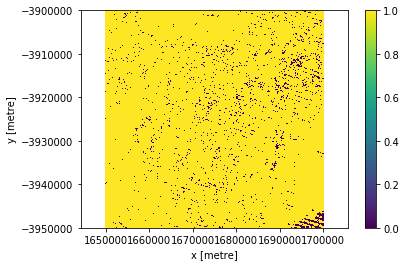

In [25]:
# executing consecutive_count function #
# Pull tv as numpy array
tv_numpy = tv.values

# Set up array for output (faster to pre-allocate for numba)
consecutive_numpy = np.empty((tv_numpy.shape[1], tv_numpy.shape[2]), dtype=np.uint8)

# Run function to get array of with 1 where number of consecutive values for different
# dates is >= required_consecutive
consecutive_numpy = consecutive_count(tv_numpy, consecutive_numpy)

# reduce original array to 2D
# using median here but not important as we just want to use shape/attributes
tv_reduce = tv.median(dim='month')

# create new data array with sampe dimensions as original
tv_summary = xr.DataArray(consecutive_numpy, coords=tv_reduce.coords, dims=tv_reduce.dims)

tv_summary.plot()
plt.axis('equal')